In [158]:
import sqlite3
import csv
import pandas as pd
import traceback
import sys
from datetime import datetime
import matplotlib.pyplot as plt

# Challenge 1

In [2]:
db = "test3.db"

## Creacion de Tablas

In [3]:
## CREACION DE TABLAS

con = sqlite3.connect(db)
cur = con.cursor()


try:
    sql_file = open("createTables.sql")
    sql_as_string = sql_file.read()
    cur.executescript(sql_as_string)
except sqlite3.Error as er:
     print('SQLite error: %s' % (' '.join(er.args)))
     print("Exception class is: ", er.__class__)
     print('SQLite traceback: ')
     exc_type, exc_value, exc_tb = sys.exc_info()
     print(traceback.format_exception(exc_type, exc_value, exc_tb))
     con.close()

con.close()

## Migrar datos desde archivos CSV

### Leer los CVS

In [4]:
depts = pd.read_csv('data/departments.csv', header=0)
emps = pd.read_csv('data/hired_employees.csv')
jobs = pd.read_csv('data/jobs.csv')

### Generar Dataframes

In [5]:
depts = pd.read_csv('data/departments.csv', header=None)
depts.columns = ['id', 'department']

jobs = pd.read_csv('data/jobs.csv', header=None)
jobs.columns = ['id', 'job']

hired_employees = pd.read_csv('data/hired_employees.csv', header=None)
hired_employees.columns = ['id', 'name', 'datetime', 'department_id', 'job_id']


### Llenar las tablas a partir de los DataFrames

In [6]:

con = sqlite3.connect(db)

try:
    depts.to_sql('departments', con, if_exists='replace', index=False)
except sqlite3.Error as er:
     print('SQLite error: %s' % (' '.join(er.args)))
     print("Exception class is: ", er.__class__)
     print('SQLite traceback: ')
     exc_type, exc_value, exc_tb = sys.exc_info()
     print(traceback.format_exception(exc_type, exc_value, exc_tb))
     
try:
    jobs.to_sql('jobs', con, if_exists='replace', index=False)
except sqlite3.Error as er:
     print('SQLite error: %s' % (' '.join(er.args)))
     print("Exception class is: ", er.__class__)
     print('SQLite traceback: ')
     exc_type, exc_value, exc_tb = sys.exc_info()
     print(traceback.format_exception(exc_type, exc_value, exc_tb))
     
try:
    hired_employees.to_sql('hired_employees', con, if_exists='replace', index=False)
except sqlite3.Error as er:
     print('SQLite error: %s' % (' '.join(er.args)))
     print("Exception class is: ", er.__class__)
     print('SQLite traceback: ')
     exc_type, exc_value, exc_tb = sys.exc_info()
     print(traceback.format_exception(exc_type, exc_value, exc_tb))
     
con.close()

## Testing cargando DataFrames desde la Base

In [7]:
depts = None
jobs = None
hired_employees = None

In [8]:
con = sqlite3.connect(db)

depts = pd.read_sql('SELECT * FROM DEPARTMENTS', con)
jobs = pd.read_sql('SELECT * FROM JOBS', con)
hired_employees = pd.read_sql('SELECT * FROM HIRED_EMPLOYEES', con)

con.close()

# Challenge 2

### Conseguir la data de la base de datos y pasarla a DataFrames

In [9]:
depts = None
jobs = None
hired_employees = None

con = sqlite3.connect(db)

depts = pd.read_sql('SELECT * FROM DEPARTMENTS', con)
jobs = pd.read_sql('SELECT * FROM JOBS', con)
hired_employees = pd.read_sql('SELECT * FROM HIRED_EMPLOYEES', con)

con.close()

In [147]:
#Cheuqeo
hired_employees.head()

,id,name,datetime,department_id,job_id
0,1,Harold Vogt,2021-11-07 02:48:42+00:00,2.0,96.0
1,2,Ty Hofer,2021-05-30 05:43:46+00:00,8.0,NaN
2,3,Lyman Hadye,2021-09-01 23:27:38+00:00,5.0,52.0
3,4,Lotti Crowthe,2021-10-01 13:04:21+00:00,12.0,71.0
4,5,Gretna Lording,2021-10-10 22:22:17+00:00,6.0,80.0


In [148]:
# Convierto a Fecha
hired_employees['datetime'] = pd.to_datetime(hired_employees['datetime'])

In [149]:

# Armo un DF filtrado año 2021 y uniendo todas las tablas para obtener los nobmres de departament y job

start = '2021-01-01'
end = '2021-12-31'

df = hired_employees[(hired_employees['datetime'] >= start) & (hired_employees['datetime'] <= end)]

df = df.join(jobs.set_index('id'), on='job_id', how='left').join(depts.set_index('id'), on='department_id', how='left')


# chequeo
df[['department', 'job']].value_counts()

department                job                       
Support                   Recruiter                     8
                          Systems Administrator IV      8
Services                  Programmer IV                 8
Research and Development  Recruiter                     6
Support                   Programmer IV                 6
                                                       ..
Marketing                 Professor                     1
                          Programmer IV                 1
                          Quality Control Specialist    1
                          Quality Engineer              1
Training                  Web Developer III             1
Length: 937, dtype: int64

### Requerimiento 1 
Number of employees hired for each job and department in 2021 divided by quarter. The table mus be ordered by department and job

In [172]:
# Acá se arma el resumen pedido
resumen = pd.pivot_table(df, index=['department','job'], values='id' , aggfunc='count', columns=df['datetime'].dt.to_period('Q'), fill_value=0)
resumen

D:\Users\juanp_schamun\AppData\Local\Temp\ipykernel_39228\86219272.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  resumen = pd.pivot_table(df, index=['department','job'], values='id' , aggfunc='count', columns=df['datetime'].dt.to_period('Q'), fill_value=0)


datetime                                  2021Q1  2021Q2  2021Q3  2021Q4
department job                                                          
Accounting Account Representative IV           1       0       0       0
           Actuary                             0       1       0       0
           Analyst Programmer                  0       0       1       0
           Budget/Accounting Analyst III       0       1       0       0
           Cost Accountant                     0       1       0       0
...                                          ...     ...     ...     ...
Training   Teacher                             0       2       0       0
           Technical Writer                    0       0       1       0
           VP Product Management               1       0       0       0
           VP Quality Control                  0       1       0       0
           Web Developer III                   0       1       0       0

[937 rows x 4 columns]

In [145]:
# Exportar a CSV
resumen.to_csv(r'resumen.csv', index=True)

### Requerimiento 2
List of ids, name and number of employees hired of each department that hired more employees tahn de mean of employees hired in 2021 for all the departments, ordered by then umber of employees hired  (descending)

<Axes: >

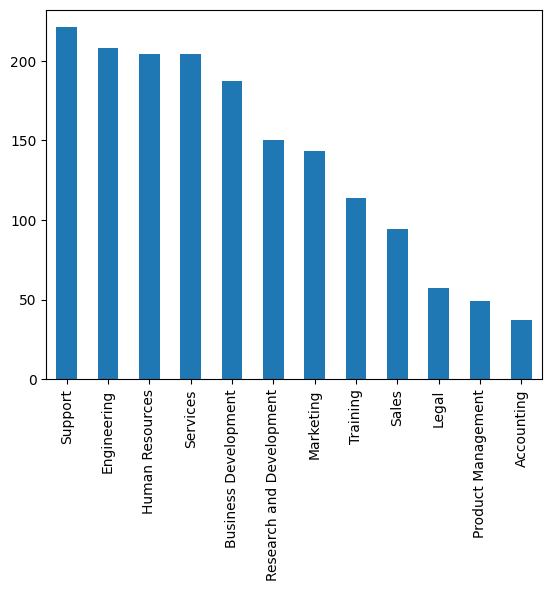

In [169]:
df['department'].value_counts().plot(kind='bar')

In [179]:
df.groupby(by='department',).count()

,id,name,datetime,department_id,job_id,job
department,,,,,,
Accounting,37,37,37,37,37,37
Business Development,187,185,187,187,187,187
Engineering,208,206,208,208,207,207
Human Resources,204,201,204,204,204,204
Legal,57,57,57,57,56,56
Marketing,143,143,143,143,142,142
Product Management,49,48,49,49,49,49
Research and Development,150,149,150,150,148,148
Sales,94,93,94,94,94,94
